In [1]:
# Install and import libraries
!pip install pandas openpyxl
import pandas as pd
import math
import numpy as np
from scipy.optimize import curve_fit
from scipy.optimize._numdiff import approx_derivative

In [3]:
# Data import
file_path = "/Users/elchulito/PlasticFADE_v2.xlsx"
sheet_name = "DS_Calibration"
data_frag = pd.read_excel(file_path, sheet_name=sheet_name, usecols="A,D:G", skiprows=1)
data_frag = data_frag[data_frag.iloc[:, 0].str.contains("F-EPS-", na=False)]
print(data_frag)

# Known variables
k_frag_i_j = data_frag.iloc[:, 1].values
s = data_frag.iloc[:, 2].values
I_j = data_frag.iloc[:, 3].values
P_j = data_frag.iloc[:, 4].values
print(I_j)

      D.P.I.  k [i,j] [d-1]   s [cm-1]  I_j [W/m2]  P_j [mW]
34  F-EPS-01       0.001138  17.258772      11.170  0.000000
35  F-EPS-02       0.000212   2.133333       9.625  0.000000
36  F-EPS-03       0.000925  17.258772       0.000  0.030626
37  F-EPS-04       0.061875   3.000000       0.000  0.059218
38  F-EPS-05       0.000003  30.000000       0.000  0.000112
39  F-EPS-06       0.000019  30.000000       4.990  0.000112
[11.17   9.625  0.     0.     0.     4.99 ]


In [17]:
# Model definition (linear popt, log params_std)
def RC_frag(params, s, I_j, P_j):
    x_i, delta_i, epsilon_I_i, alpha_i, epsilon_P_i, beta_i = params
    return x_i * (s**delta_i) * (I_j + epsilon_I_i)**alpha_i * (P_j + epsilon_P_i)**beta_i

# Log-space curve fitting (more suitable for rate constants spanning orders of magnitude)
def log_model_frag(inputs, x_i, delta_i, epsilon_I_i, alpha_i, epsilon_P_i, beta_i):
    s, I_j, P_j = inputs
    params = [x_i, delta_i, epsilon_I_i, alpha_i, epsilon_P_i, beta_i]
    k_frag = RC_frag(params, s, I_j, P_j)
    return np.log(k_frag)

# Prepare inputs (X) and outputs (Y) arrays
X = (s, I_j, P_j)
Y = np.log(k_frag_i_j)

# Fitting settings (Initial guesses, bounds, convergence threshold, maximum iterations)
initial_guess = [1, 1, 1, 1, 1, 1]
bounds = ([0]*6, [np.inf]*6) # Lower and upper bounds
tolerance = 0.001  # 0.1%
max_iterations = 1000

# The loop for iterations
for iteration in range(max_iterations):
    # Perform curve fitting (maxfev: maximum function evaluations, which is calculated as: maxfev=200×(number of parameters + 1)
    # Fit log-transformed model to log-transformed data
    popt, pcov = curve_fit(log_model_frag, X, Y, p0=initial_guess, bounds=bounds, maxfev=5000)
    # Calculate the relative difference
    relative_diff = np.abs(popt - initial_guess) / np.abs(initial_guess)
    # Update the initial guess
    initial_guess = popt
    # Check for convergence
    if np.all(relative_diff < tolerance):
        print(f"Converged after {iteration + 1} iterations.")
        break
else:
    print("Reached the maximum number of iterations without full convergence.")

# Fitted parameters (i.e., parameter estimates), in linear space
parameter_names = ['x_i', 'delta_i', 'epsilon_I_i', 'alpha_i', 'epsilon_P_i', 'beta_i']
for name, value in zip(parameter_names, popt):
    print(f"{name}: {value}")

Converged after 2 iterations.
x_i: 6.95051536950565e-09
delta_i: 0.19965901560841948
epsilon_I_i: 27.727456400087807
alpha_i: 17.459840938898175
epsilon_P_i: 0.09943343274030703
beta_i: 22.935277890644997


/var/folders/_j/jvdb8rz100z48jv89nnnmdlw0000gn/T/ipykernel_67611/4013803383.py:27: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(log_model_frag, X, Y, p0=initial_guess, bounds=bounds, maxfev=5000)


In [19]:
# Save fitted parameters back to Excel (without modifying)
import xlwings as xw

# File path and sheet details
file_path = "/Users/elchulito/PlasticFADE_v2.xlsx"
sheet_name = "Drop-down lists"
start_row = 10  # Change for other polymer types (4-13)
start_col = "C"

# Fitted parameters
fitted_parameters = popt

# Start the Excel application and open the workbook
app = xw.App(visible=True)  # Set visible=True to open the file automatically
workbook = app.books.open(file_path)
sheet = workbook.sheets[sheet_name]

# Write the fitted parameters to the specified cells
for i, value in enumerate(fitted_parameters):
    column = chr(ord(start_col) + i)
    cell = f"{column}{start_row}"
    sheet.range(cell).value = value

# Save the workbook
workbook.save()
workbook.close()
app.quit()

In [21]:
# Compute determination coefficient (R^2) while fully staying in log-space
# Step 1: Compute log-observed and log-predicted
eps = 1e-10  # Small constant to avoid log(0) issues
log_obs = np.log(k_frag_i_j + eps)  # Avoid log(0)
log_pred = log_model_frag(X, *popt)  # Already log(k_pred)


# Step 2: Compute SS_res and SS_tot in log-space
ss_res_log = np.sum((log_obs - log_pred)**2)
ss_tot_log = np.sum((log_obs - np.mean(log_obs))**2)

# Step 3: Compute R² in log-space
r_squared_log = 1 - (ss_res_log / ss_tot_log)
print(f"Log-space R² (pseudo-R²): {r_squared_log:.3f}")

Log-space R² (pseudo-R²): 0.984


In [15]:
# Compute the Fisher Information Matrix
from scipy.optimize._numdiff import approx_derivative

# --- Step 1: Define the wrapped model for Jacobian estimation ---
def wrapped_model(params):
    return np.log(model_frag(inputs, *params))  # Assuming log-normally distributed residuals

# --- Step 2: Compute residuals and estimated variance ---
residuals = np.log(k_frag_i_j) - wrapped_model(popt)  # log of observed data - log of model output
sigma2 = np.var(residuals, ddof=1)

# --- Step 3: Compute the Jacobian at fitted parameters ---
# J = approx_derivative(wrapped_model, popt, method='2-point/3-point')
J = approx_derivative(wrapped_model, popt, method='cs')

# --- Step 4: Compute Fisher Information Matrix (round to 3 significant digits) ---
FIM = (1 / sigma2) * J.T @ J

# --- Step 5: Compute standard deviations from the inverse of FIM ---
# cov_est = np.linalg.inv(FIM)
cov_est = np.linalg.pinv(FIM) # Uses the Moore–Penrose pseudo-inverse, which handles rank-deficient matrices gracefully
param_std = np.sqrt(np.diag(cov_est))

# --- Step 6: Compute relative uncertainty
param_names = ['a_i', 'delta_i', 'b_i', 'alpha_i', 'c_i', 'beta_i']
relative_uncertainty = 100 * param_std / np.abs(popt)

# --- Format all values as strings with 3 significant digits ---
summary_df = pd.DataFrame({
    'Parameter': param_names,
    'Estimate': popt,
    'Std. Dev (σ)': param_std,
    'Relative Uncertainty (%)': relative_uncertainty
})

# --- Output ---
pd.set_option('display.float_format', '{:.2e}'.format)
print("Inverse of Fisher Information Matrix (parameter covariance matrix):")
print(np.array2string(cov_est, formatter={'float_kind': lambda x: f"{x:.2e}"}))
print("\nStandard deviations of parameter estimates (Cramér–Rao bounds): See the table below")
print("📋 Relative Uncertainty Table:")
print(summary_df.to_string(index=False))
print("\nNumber of residuals:", len(residuals))

Inverse of Fisher Information Matrix (parameter covariance matrix):
[[2.84e-05 1.81e-03 -4.00e-11 -7.12e-06 3.19e-08 -3.76e-03]
 [1.81e-03 1.15e-01 -2.54e-09 -4.52e-04 2.03e-06 -2.39e-01]
 [-4.00e-11 -2.54e-09 2.99e-15 1.00e-11 -4.49e-14 5.29e-09]
 [-7.12e-06 -4.52e-04 1.00e-11 1.78e-06 -7.97e-09 9.41e-04]
 [3.19e-08 2.03e-06 -4.49e-14 -7.97e-09 3.57e-11 -4.21e-06]
 [-3.76e-03 -2.39e-01 5.29e-09 9.41e-04 -4.21e-06 4.97e-01]]

Standard deviations of parameter estimates (Cramér–Rao bounds): See the table below
📋 Relative Uncertainty Table:
Parameter  Estimate  Std. Dev (σ)  Relative Uncertainty (%)
      a_i  2.13e+01      5.33e-03                  2.50e-02
  delta_i  1.34e-02      3.39e-01                  2.53e+03
      b_i  7.37e-11      5.47e-08                  7.42e+04
  alpha_i  5.60e+00      1.33e-03                  2.38e-02
      c_i  1.90e+04      5.98e-06                  3.14e-08
   beta_i  5.56e+00      7.05e-01                  1.27e+01

Number of residuals: 7


In [17]:
# Save standard deviations and relative uncertainty of fitted parameters back to Excel (without modifying)
import xlwings as xw

cols_to_write = ['Estimate', 'Std. Dev (σ)', 'Relative Uncertainty (%)']
data_to_write = summary_df[cols_to_write].values.tolist()

wb = xw.Book('/Users/elchulito/Library/CloudStorage/OneDrive-polymtlus/0 - A_Database and methodology_PhD/PlasticFADE.xlsx')  # Use full path if not in working directory
ws = wb.sheets['Uncertainty']

start_cell = 'H15'  # Change this index for other polymers
ws.range(start_cell).value = data_to_write

wb.save()
wb.close()

In [25]:
# Import the original data points and calculated RCs from PlasticFADE
import matplotlib.pyplot as plt
file_path = "/Users/elchulito/PlasticFADE_v2.xlsx"
data_comp = pd.read_excel(file_path, sheet_name="Scatterplot", usecols="A:D", skiprows=5)
data_comp = data_comp[data_comp.iloc[:, 0].str.contains("F-EPS-", na=False)]
pd.set_option('display.float_format', '{:.2e}'.format)
print(data_comp)

      D.P.I. R.E.S. k_model [d-1] k [i,j] [d-1]
51  F-EPS-01     UV      7.19e-04      1.14e-03
52  F-EPS-02     UV      2.34e-04      2.12e-04
53  F-EPS-03     MS      9.22e-04      9.25e-04
54  F-EPS-04     MS      6.20e-02      6.19e-02
55  F-EPS-05     MS      2.24e-06      3.33e-06
56  F-EPS-06  UV+MS      4.02e-05      1.87e-05


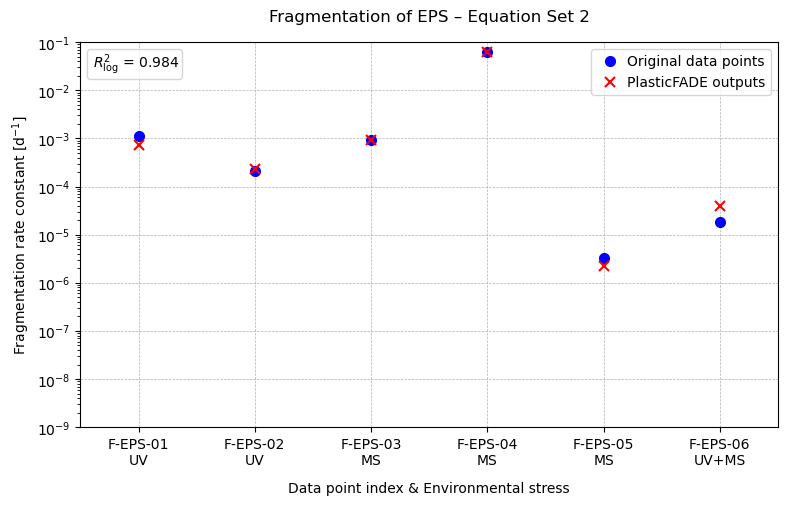

In [27]:
# Plot the modeling results with the original data points in the same graph
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(9, 5))
df = pd.DataFrame(data_comp)
df['x_labels'] = df['D.P.I.'] + '\n' + df['R.E.S.']

# Plot original data and model output
ax.plot(df['D.P.I.'], df['k [i,j] [d-1]'], 'bo', markersize=7, label='Original data points')
ax.plot(df['D.P.I.'], df['k_model [d-1]'], 'rx', markersize=7, markeredgewidth=1.5, label='PlasticFADE outputs')

# Main legend
main_legend = ax.legend(loc='upper right', handletextpad=0.2)
ax.add_artist(main_legend)  # keep it when adding another legend

# --- Create second legend entry for R² without marker ---
r2_label = f'$R_{{\\mathrm{{log}}}}^2$ = {r_squared_log:.3f}'

# Make an invisible Line2D object (no line, no marker)
empty_line = Line2D([], [], color='none')

# Add the second legend with zero padding before the text
r2_legend = ax.legend([empty_line], [r2_label], loc='upper left', frameon=True, handlelength=0, handletextpad=0.2, borderpad=0.2)

plt.xticks(df['D.P.I.'], df['x_labels'])
plt.xlim(-0.5, len(data_comp) - 0.5)
ax.set_xlabel('Data point index & Environmental stress', labelpad=10)
ax.set_ylabel('Fragmentation rate constant [d$^{-1}$]')
ax.set_yscale('log')
ax.set_ylim(1e-9, 1e-1)
ax.grid(True, which="major", ls="--", lw=0.5)
ax.set_title('Fragmentation of EPS – Equation Set 2', pad=15)

plt.savefig("/Users/elchulito/F_EPS_S2.png", dpi=600, bbox_inches='tight')
plt.show()